# Data preparation

In [1]:
library(DESeq2)
library(ggplot2)
library(pheatmap)
library(dplyr)
library(tidyverse)
library(reshape2)
library(ggrepel)
library(data.table)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    Filter, Find, Map, Position, Reduce, anyDuplicated, aperm, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, saveRDS, setdiff, table,
    tapply, union, unique, unsplit, which.max, which.min



Attaching package: 'S4Vectors'


The following object is masked from 'package:utils':

    findMatches


The following objects are masked from 'package:base':

    I, expand.grid, unname


Loading required package: IRanges

Loading required package: GenomicRanges

Loading required package: GenomeInfoDb



In [2]:
library(RColorBrewer)

## Set a color-blind friendly palette
heat_colors <- rev(brewer.pal(11, "RdBu"))
heat_colors

[1] "#053061" "#2166AC" "#4393C3" "#92C5DE" "#D1E5F0" "#F7F7F7" "#FDDBC7"
 [8] "#F4A582" "#D6604D" "#B2182B" "#67001F"

In [3]:
# load dds object
dds <- readRDS("data/dds.rds")
dds

class: DESeqDataSet 
dim: 14430 6 
metadata(1): version
assays(4): counts mu H cooks
rownames(14430): 7SK A1BG-AS1 ... hsa-mir-8072 snoU2_19
rowData names(22): baseMean baseVar ... deviance maxCooks
colnames(6): X_filesTien_Cont1_S25sorted X_filesTien_Cont2_S26sorted
  ... X_filesTien_Zn2_S29sorted X_filesTien_Zn3_S30sorted
colData names(2): condition sizeFactor

# Visualization of Differential Expression Genes

In this section, we will generate some key data tables and use a different visualization techniques to explore our results, including:
- Table of results for all genes
- Table of results for significant genes (adjusted p-value < 0.05)
- Scatterplot of normalized expression of top 20 most significant genes
- Heatmap of all significant genes
- Volcano plot of results for all genes

In [4]:
# read results from file
res_tbl <- read.csv("data/E_vs_C_all_genes.csv", row.names = 1)
res_tbl <- res_tbl %>%
  data.frame() %>%
  rownames_to_column(var = "gene") %>%
  as_tibble() %>%
  arrange(padj)

head(res_tbl)

gene,baseMean,log2FoldChange,lfcSE,pvalue,padj
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MT-RNR2,904848.616,2.307590,0.02724077,0.000000e+00,0.000000e+00
MT-TP,3253.096,1.944385,0.05412532,1.003573e-284,5.411264e-281
MT-ND5,298801.231,1.111986,0.03115547,4.333748e-280,1.557838e-276
MTRNR2L2,2609.833,1.974944,0.05587488,2.128453e-275,5.738310e-272
MT-ATP6,118615.796,-1.112057,0.03392554,7.591171e-237,1.637264e-233
MT-ATP8,43908.463,-1.334777,0.04099192,5.001372e-234,8.989132e-231


## Table of results for significant genes

Filter our table to extract only the significant genes using a p-adjusted threshold of `0.05`:

The `arrange` function sorts the rows of the filtered data frame (sig_res) in ascending order based on the padj column. Rows with smaller padj values appear first.

In [5]:
# Set thresholds
padj_cutoff <- 0.05

# records before
nrow_before <- nrow(res_tbl)

# Subset the significant results
sig_res <- dplyr::filter(res_tbl, padj < padj_cutoff) %>%
  dplyr::arrange(padj)

# records after
nrow_after <- nrow(sig_res)

# print the number of significant results
cat("Total records:", nrow_before, "\n")
cat("Number of significant results:", nrow_after, "\n")
cat("Percentage of significant results:", nrow_after / nrow_before * 100, "%\n")

Total records: 14430 
Number of significant results: 1770 
Percentage of significant results: 12.26611 %


In [6]:
# Write significant results to the "data/" directory
condition <- factor(c("C", "C", "C", "E", "E", "E"))

save_path <- file.path(
  "data",
  paste0(levels(condition)[2], "_vs_", levels(condition)[1],
         "_signif_genes.csv")
)
write.csv(res_tbl,
          file = save_path,
          quote = FALSE,
          row.names = FALSE)

## Fold change

We may also be interested in determining the total number of significantly upregulated or downregulated genes above a certain fold change threshold (for example log2 fold change (in absolute value) >0.58, which corresponds to a ~50% increase (or ~30% decrease) in gene expression.

The main reasons for calculating **log fold change** in DEG analysis are:

1. **Normalization of Data**: Log transformation helps normalize the data, especially when there are large differences in gene expression. Fold change values can vary dramatically between genes (e.g., a gene with fold change 2 might be considered significant, but 10,000 fold change would be a huge outlier).
   
2. **Symmetry**: Log fold change (typically log2) ensures that the scale is symmetric. A 2-fold upregulation (FC = 2) and a 2-fold downregulation (FC = 0.5) will both result in a log fold change of +1 and -1, respectively. This symmetry makes it easier to interpret upregulations and downregulations.
   
3. **Handling Small and Large Changes**: The log scale compresses the range of values, which allows both small and large changes to be analyzed in a comparable manner. For example, a fold change of 10,000 becomes a manageable value when transformed into a log scale (log2(10000) ≈ 13.29).
   
4. **Statistical Analysis**: Log-transformed data are more likely to conform to the assumptions of statistical tests (e.g., normality and variance homogeneity), making the results more reliable.

In summary, **log fold change** is used to make gene expression changes more interpretable, stable, and statistically robust, particularly when working with wide-ranging data across different genes or conditions.

In [7]:
# Set thresholds
log2fc_cutoff <- 0.58

# Count significantly up/down genes above threshold
n_sig_up <- dplyr::filter(sig_res, log2FoldChange >= log2fc_cutoff) %>%
  nrow()
n_sig_dn <- dplyr::filter(sig_res, log2FoldChange <= -log2fc_cutoff) %>%
  nrow()

# print the number of significantly up/down genes
cat("Number of significantly up-regulated genes:", n_sig_up, "\n")
cat("Number of significantly down-regulated genes:", n_sig_dn, "\n")  

Number of significantly up-regulated genes: 203 
Number of significantly down-regulated genes: 143 


## Scatterplot of top 20 most significant genes

In [8]:
## Extract normalized counts from dds object
normalized_counts <- counts(dds, normalized = TRUE)

## Extract top 20 DEG from resLFC (make sure to order by padj)
top20_sig_genes <- sig_res %>%
  dplyr::arrange(padj) %>%
  dplyr::pull(gene) %>%
  head(n = 20)

## Extract matching normalized count values from matrix
cond_matched_counts <- rownames(normalized_counts) %in% top20_sig_genes
top20_sig_counts <- normalized_counts[cond_matched_counts, ]
top20_sig_counts

,X_filesTien_Cont1_S25sorted,X_filesTien_Cont2_S26sorted,X_filesTien_Cont3_S27sorted,X_filesTien_Zn1_S28sorted,X_filesTien_Zn2_S29sorted,X_filesTien_Zn3_S30sorted
ANXA1,241.17530,176.84471,181.37622,1267.9014,1222.4770,1117.2169
BTG2,98.25660,97.19709,126.86687,720.0637,729.7701,678.4756
CDKN1A,160.78354,160.64519,162.08087,979.5359,943.1269,954.3088
FOSL1,142.91870,206.54382,222.86120,1036.1893,1112.9154,930.2428
GDF15,71.45935,78.97264,81.04044,792.5800,759.8835,712.7233
MT-ATP6,158023.41768,160611.44140,168108.73819,77062.6821,75300.8684,72587.6307
MT-ATP8,66412.53239,64012.38351,58429.19007,24747.8709,25129.3350,24719.4663
MT-CYB,164302.90796,155673.28924,161521.79079,251731.1076,261758.7275,271696.6098
MT-ND3,24108.59784,24275.64820,24548.49894,41215.8587,41038.1948,40513.2300
MT-ND5,191600.37924,184060.23936,191259.28960,408937.2794,397685.6143,419264.5853


In [9]:
## Convert wide matrix to long data frame for ggplot2
top20_sig_df <- data.frame(top20_sig_counts)
top20_sig_df$gene <- rownames(top20_sig_counts)
top20_sig_df

,X_filesTien_Cont1_S25sorted,X_filesTien_Cont2_S26sorted,X_filesTien_Cont3_S27sorted,X_filesTien_Zn1_S28sorted,X_filesTien_Zn2_S29sorted,X_filesTien_Zn3_S30sorted,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ANXA1,241.17530,176.84471,181.37622,1267.9014,1222.4770,1117.2169,ANXA1
BTG2,98.25660,97.19709,126.86687,720.0637,729.7701,678.4756,BTG2
CDKN1A,160.78354,160.64519,162.08087,979.5359,943.1269,954.3088,CDKN1A
FOSL1,142.91870,206.54382,222.86120,1036.1893,1112.9154,930.2428,FOSL1
GDF15,71.45935,78.97264,81.04044,792.5800,759.8835,712.7233,GDF15
MT-ATP6,158023.41768,160611.44140,168108.73819,77062.6821,75300.8684,72587.6307,MT-ATP6
MT-ATP8,66412.53239,64012.38351,58429.19007,24747.8709,25129.3350,24719.4663,MT-ATP8
MT-CYB,164302.90796,155673.28924,161521.79079,251731.1076,261758.7275,271696.6098,MT-CYB
MT-ND3,24108.59784,24275.64820,24548.49894,41215.8587,41038.1948,40513.2300,MT-ND3


- `id.vars = c("gene")`: Specifies that the column `gene` should remain as is (it’s the identifier variable and will not be melted).
- `variable.name = "sample_id"`: Renames the column containing the variable names (e.g., sample columns in the wide format) to `sample_id`.

In [10]:
top20_sig_df <- melt(setDT(top20_sig_df),
                     id.vars = c("gene"),
                     variable.name = "sample_id") %>%
  data.frame()
head(top20_sig_df)

,gene,sample_id,value
,<chr>,<fct>,<dbl>
1,ANXA1,X_filesTien_Cont1_S25sorted,241.17530
2,BTG2,X_filesTien_Cont1_S25sorted,98.25660
3,CDKN1A,X_filesTien_Cont1_S25sorted,160.78354
4,FOSL1,X_filesTien_Cont1_S25sorted,142.91870
5,GDF15,X_filesTien_Cont1_S25sorted,71.45935
6,MT-ATP6,X_filesTien_Cont1_S25sorted,158023.41768


In [11]:
head(counts(dds))

,X_filesTien_Cont1_S25sorted,X_filesTien_Cont2_S26sorted,X_filesTien_Cont3_S27sorted,X_filesTien_Zn1_S28sorted,X_filesTien_Zn2_S29sorted,X_filesTien_Zn3_S30sorted
7SK,0,11,18,10,17,7
A1BG-AS1,7,24,46,59,30,20
A2M-AS1,2,76,95,48,35,25
A2ML1-AS1,2,37,30,28,26,17
A2ML1-AS2,3,12,17,8,9,15
A2MP1,2,16,32,23,12,23


In [12]:
colData(dds)

DataFrame with 6 rows and 2 columns
                            condition sizeFactor
                             <factor>  <numeric>
X_filesTien_Cont1_S25sorted         C   0.111952
X_filesTien_Cont2_S26sorted         C   1.481526
X_filesTien_Cont3_S27sorted         C   2.073039
X_filesTien_Zn1_S28sorted           E   1.765122
X_filesTien_Zn2_S29sorted           E   1.560766
X_filesTien_Zn3_S30sorted           E   1.080363

In [13]:
rownames(colData(dds))

[1] "X_filesTien_Cont1_S25sorted" "X_filesTien_Cont2_S26sorted"
[3] "X_filesTien_Cont3_S27sorted" "X_filesTien_Zn1_S28sorted"  
[5] "X_filesTien_Zn2_S29sorted"   "X_filesTien_Zn3_S30sorted"

In [14]:
## Create the sample_id column
colData(dds)$sample_id <- rownames(colData(dds))

## Join counts data frame with metadata
top20_sig_df <- merge(
  top20_sig_df,
  as.data.frame(colData(dds)),
  by = "sample_id",
  all.x = TRUE
)
head(top20_sig_df)

,sample_id,gene,value,condition,sizeFactor
,<fct>,<chr>,<dbl>,<fct>,<dbl>
1,X_filesTien_Cont1_S25sorted,ANXA1,241.17530,C,0.1119518
2,X_filesTien_Cont1_S25sorted,BTG2,98.25660,C,0.1119518
3,X_filesTien_Cont1_S25sorted,CDKN1A,160.78354,C,0.1119518
4,X_filesTien_Cont1_S25sorted,FOSL1,142.91870,C,0.1119518
5,X_filesTien_Cont1_S25sorted,GDF15,71.45935,C,0.1119518
6,X_filesTien_Cont1_S25sorted,MT-ATP6,158023.41768,C,0.1119518


**Aesthetic** mappings describe how variables in the data are mapped
 to visual properties (aesthetics) of geoms. Aesthetic mappings can
 be set in ‘ggplot()’ and in individual layers.

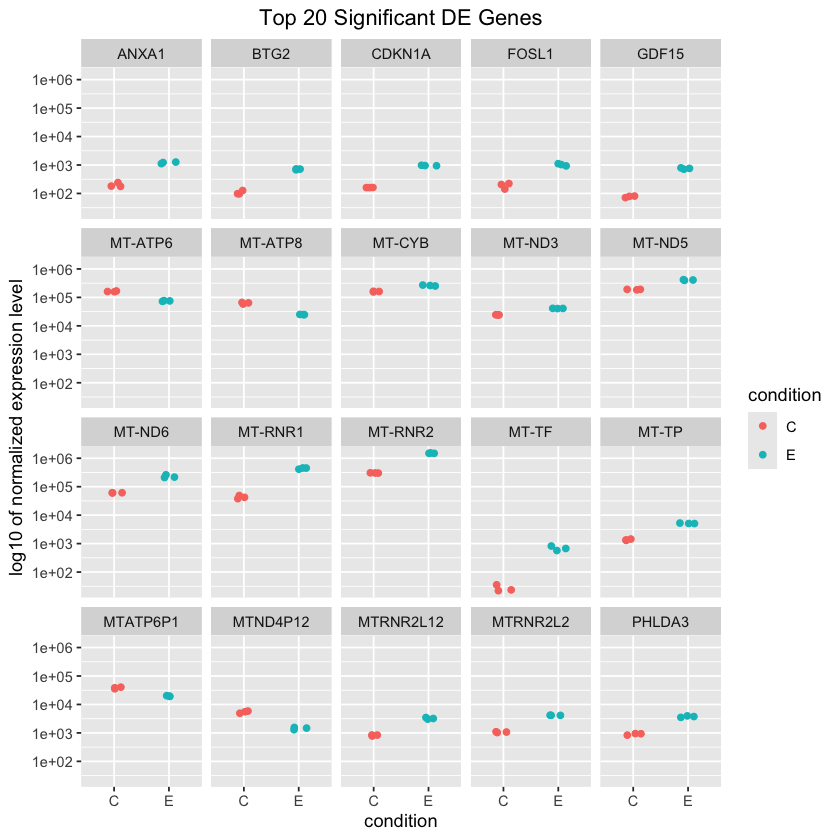

In [15]:
## Generate plot
# Initializes the plot with the dataset top20_sig_df and specifies the aesthetics (the mapping of data to plot elements).
ggplot(top20_sig_df, aes(y = value, x = condition, col = condition)) +

# Adds jittered points (scatterplot with slight random horizontal offsets) to avoid overlapping of points.
geom_jitter(height = 0, width = 0.15) +

# Transforms the y-axis to a log10 scale, making it easier to visualize data with large variations in magnitude (e.g., gene expression levels).
scale_y_continuous(trans = 'log10') +

ylab("log10 of normalized expression level") +
xlab("condition") +
ggtitle("Top 20 Significant DE Genes") +
theme(plot.title = element_text(hjust = 0.5)) +
facet_wrap(~ gene)

## Heatmap of all significant genes

In [16]:
## Extract normalized counts for significant genes only
sig_counts <- normalized_counts[rownames(normalized_counts) %in% sig_res$gene, ]
nrow(sig_counts)
head(sig_counts)

[1] 1770

,X_filesTien_Cont1_S25sorted,X_filesTien_Cont2_S26sorted,X_filesTien_Cont3_S27sorted,X_filesTien_Zn1_S28sorted,X_filesTien_Zn2_S29sorted,X_filesTien_Zn3_S30sorted
AARSD1,26.79726,47.24859,46.30882,84.97998,84.57388,81.45409
ABAT,330.49949,453.58642,483.83070,260.03875,294.08645,277.68441
ABCC2,53.59451,32.39903,44.86167,74.78239,73.04108,81.45409
ABCF2,2054.45628,1765.74713,1912.16840,2002.12842,2236.72289,2186.30193
ABHD17B,1062.95781,1137.34095,1126.36559,944.97742,1007.19805,847.86307
ABHD4,875.37702,891.64830,940.64793,751.22306,773.97916,703.46718


In [17]:
colData(dds)$sample_id <- as.factor(colData(dds)$sample_id)
colData(dds)

DataFrame with 6 rows and 3 columns
                            condition sizeFactor                   sample_id
                             <factor>  <numeric>                    <factor>
X_filesTien_Cont1_S25sorted         C   0.111952 X_filesTien_Cont1_S25sorted
X_filesTien_Cont2_S26sorted         C   1.481526 X_filesTien_Cont2_S26sorted
X_filesTien_Cont3_S27sorted         C   2.073039 X_filesTien_Cont3_S27sorted
X_filesTien_Zn1_S28sorted           E   1.765122 X_filesTien_Zn1_S28sorted  
X_filesTien_Zn2_S29sorted           E   1.560766 X_filesTien_Zn2_S29sorted  
X_filesTien_Zn3_S30sorted           E   1.080363 X_filesTien_Zn3_S30sorted  

In [18]:
# Create sample names vector
samples <- c("X_filesTien_Cont1_S25sorted", "X_filesTien_Cont2_S26sorted", "X_filesTien_Cont3_S27sorted", "X_filesTien_Zn1_S28sorted", "X_filesTien_Zn2_S29sorted", "X_filesTien_Zn3_S30sorted")

# Create condition vector
condition <- c("C", "C", "C", "E", "E", "E")

# Create data frame
col_name <- data.frame(
  row.names = samples,
  condition = factor(condition)
)

# View the data frame
col_name

,condition
,<fct>
X_filesTien_Cont1_S25sorted,C
X_filesTien_Cont2_S26sorted,C
X_filesTien_Cont3_S27sorted,C
X_filesTien_Zn1_S28sorted,E
X_filesTien_Zn2_S29sorted,E
X_filesTien_Zn3_S30sorted,E


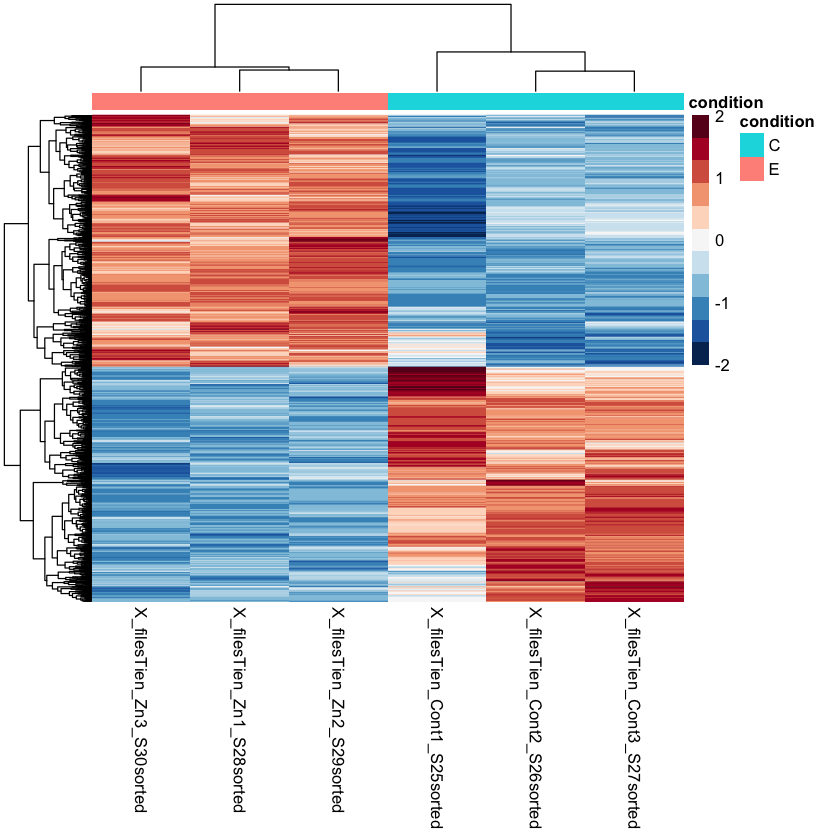

In [19]:
## Run pheatmap using the metadata data frame for the annotation
# The heatmap visualizes the expression values of these genes across samples.
# Groups genes with similar expression patterns together, improving interpretability.
pheatmap(sig_counts,
         color = heat_colors,
         cluster_rows = TRUE,
         show_rownames = FALSE,
         annotation = col_name,
         border_color = NA,
         fontsize = 10,
         scale = "row",
         fontsize_row = 10,
         height = 20)

## Volcano plot

- Filters out rows where the padj (adjusted p-value) is NA. Genes without statistical significance are excluded.
- Adds a new column, threshold, which indicates whether a gene meets the significance criteria:

In [20]:
# Volcano plot
res_table_thres <- res_tbl[!is.na(res_tbl$padj), ] |>
  mutate(threshold = padj < padj_cutoff & abs(log2FoldChange) >= log2fc_cutoff)

head(res_table_thres)
min(log10(res_table_thres$padj))

gene,baseMean,log2FoldChange,lfcSE,pvalue,padj,threshold
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
MT-RNR2,904848.616,2.307590,0.02724077,0.000000e+00,0.000000e+00,TRUE
MT-TP,3253.096,1.944385,0.05412532,1.003573e-284,5.411264e-281,TRUE
MT-ND5,298801.231,1.111986,0.03115547,4.333748e-280,1.557838e-276,TRUE
MTRNR2L2,2609.833,1.974944,0.05587488,2.128453e-275,5.738310e-272,TRUE
MT-ATP6,118615.796,-1.112057,0.03392554,7.591171e-237,1.637264e-233,TRUE
MT-ATP8,43908.463,-1.334777,0.04099192,5.001372e-234,8.989132e-231,TRUE


[1] -Inf

In [21]:
# value counts threshold
table(res_table_thres$threshold)


FALSE  TRUE 
10438   346 

In [22]:
# Prepare the data dataframe
data <- res_tbl[!is.na(res_tbl$padj), ]

# Add a sig column
# Default value is "ns" (not significant).
# "Up": Genes with log2FoldChange >= 2 (upregulated) and padj < 0.05.
# "Down": Genes with log2FoldChange <= -2 (downregulated) and padj < 0.05.
data$sig <- "ns"
data$sig[data$log2FoldChange >= 2 & data$padj < 0.05] <- "Up"
data$sig[data$log2FoldChange <= -2 & data$padj < 0.05] <- "Down"

# Extract significant genes
# contains only the significant genes (both upregulated and downregulated).
sigs_df <- data[abs(data$log2FoldChange) >= 2 & data$padj < 0.05, ]
nrow(sigs_df)
head(sigs_df)

[1] 33

gene,baseMean,log2FoldChange,lfcSE,pvalue,padj,sig
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
MT-RNR2,904848.6162,2.307590,0.02724077,0.000000e+00,0.000000e+00,Up
PHLDA3,2324.6078,2.068445,0.06995754,6.609096e-194,1.018179e-190,Up
MT-RNR1,241605.1561,3.347647,0.11542506,2.774468e-186,3.739983e-183,Up
ANXA1,701.1653,2.701233,0.11406008,3.068220e-126,3.007972e-123,Up
CDKN1A,560.0802,2.561907,0.11066463,8.385615e-120,7.535873e-117,Up
GDF15,416.1099,3.235153,0.13982884,2.376067e-119,1.971039e-116,Up


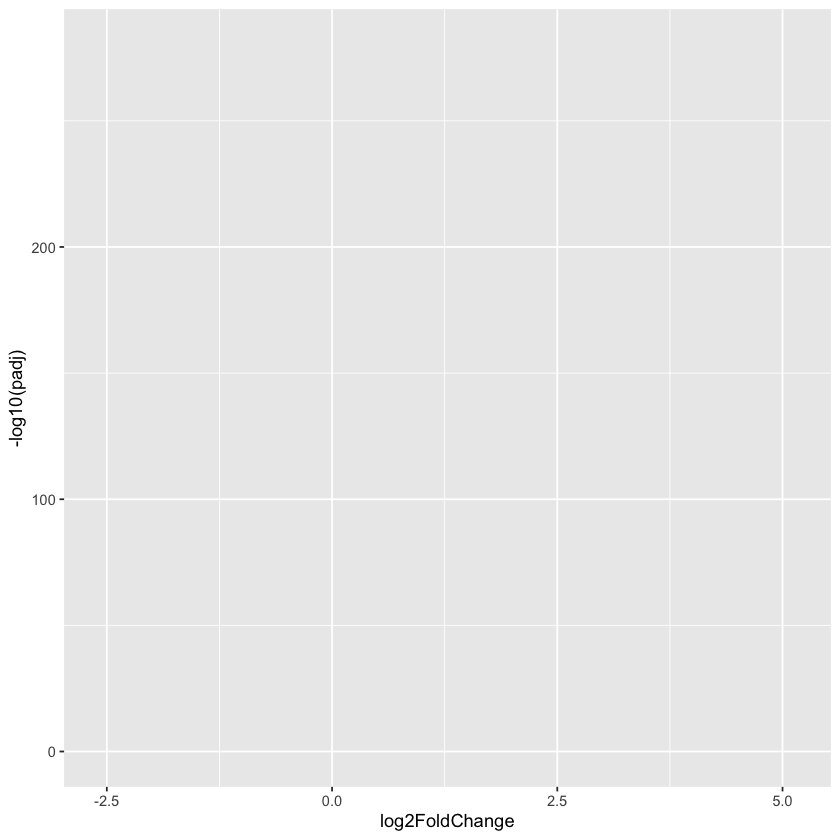

In [23]:
# Initialize the Plot
# X-axis: log2FoldChange (magnitude of gene expression change).
# Y-axis: -log10(padj) (statistical significance,
# with smaller padj values being more significant).
p_vol <- ggplot(data = data,
                aes(x = log2FoldChange,
                    y = -log10(padj)))
p_vol

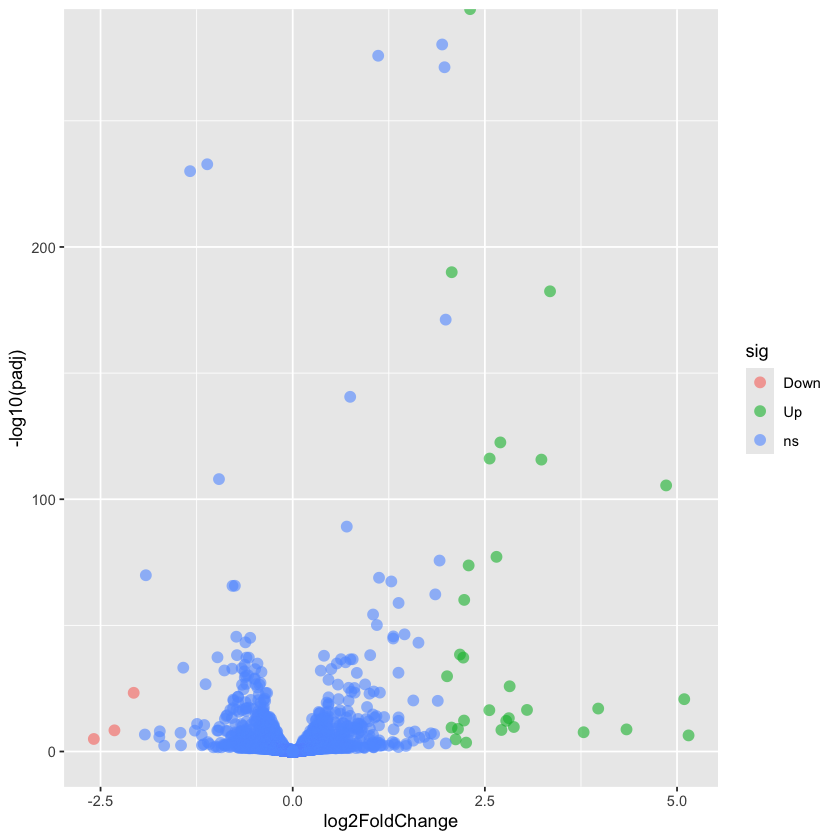

In [24]:
# Add points
p_vol <- p_vol +
  geom_point(aes(colour = sig),
             alpha = 0.6,
             shape = 16,
             size = 3)

p_vol

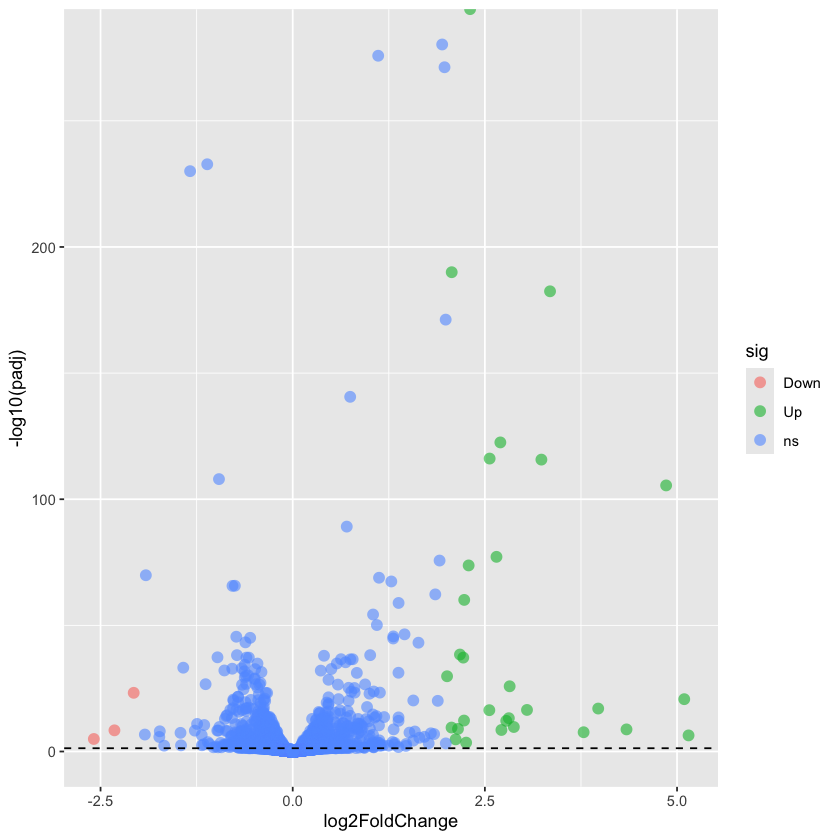

In [25]:
# Add Horizontal Line
# Indicates the statistical significance threshold (e.g., padj = 0.05).
p_vol <- p_vol +
  geom_hline(yintercept = -log10(0.05),
             linetype = "dashed")
p_vol

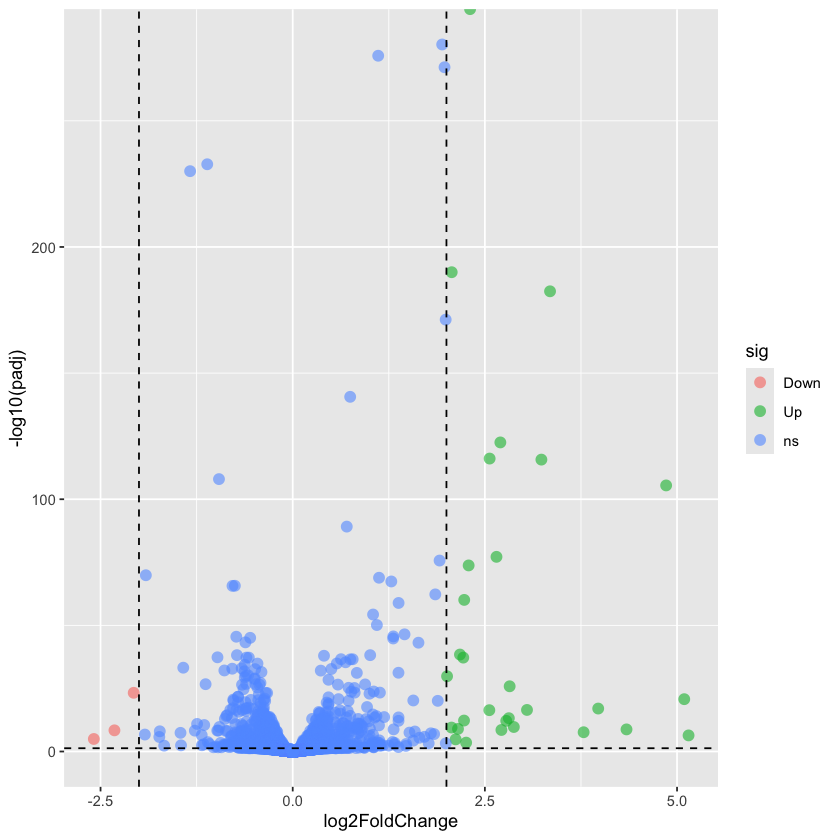

In [26]:
# Add Vertical Lines
# Marks the fold-change thresholds
# (e.g., a 4-fold change in expression corresponds to ±log2(4)).
p_vol <- p_vol +
  geom_vline(xintercept = c(-log2(4), log2(4)),
             linetype = "dashed")
p_vol

Warning message:
"ggrepel: 11 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


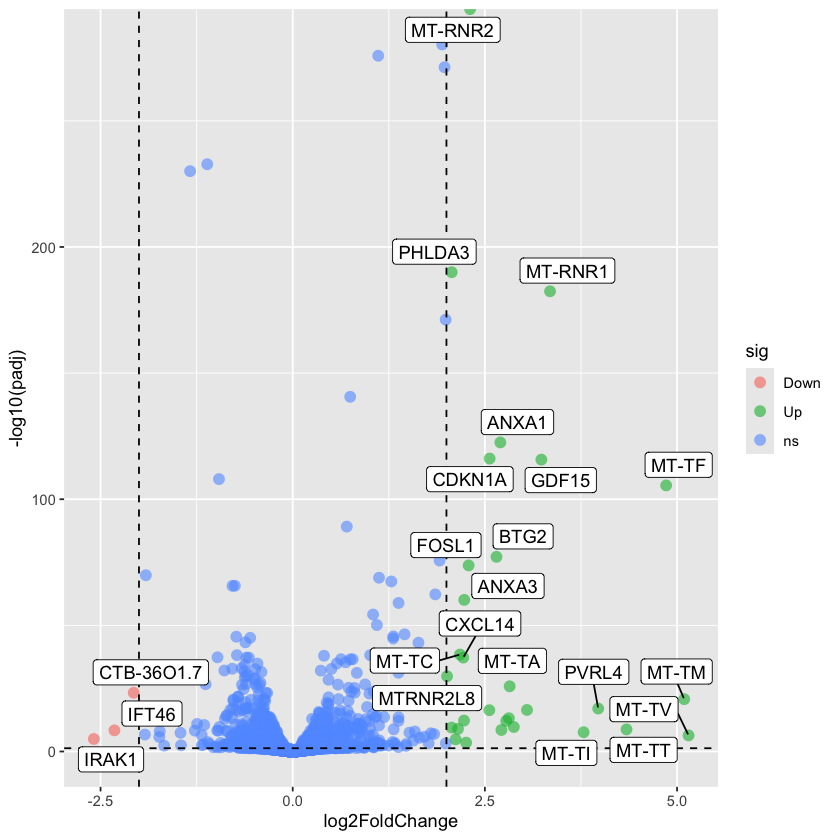

In [27]:
# Add Gene Labels
# Prevents overlapping labels by repelling them away from each other.

p_vol <- p_vol +
  geom_label_repel(data = sigs_df,
                   aes(label = gene),
                   force = 2,
                   nudge_y = 1)
p_vol

Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`)."
Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_label_repel()`)."
Warning message:
"ggrepel: 13 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


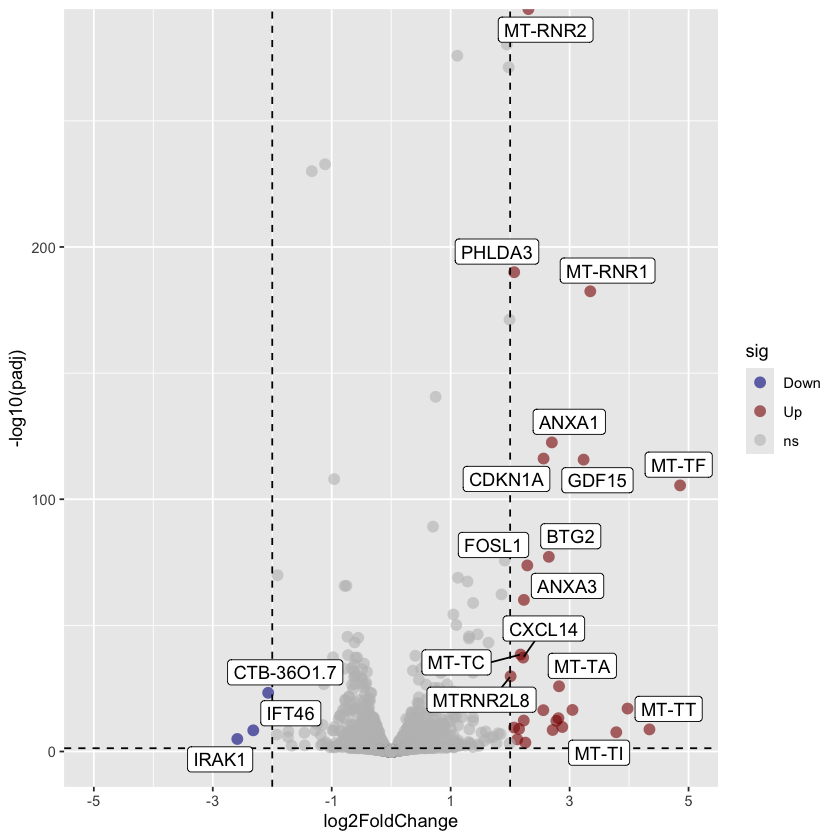

In [28]:
# Customize Colors
p_vol <- p_vol +
  scale_colour_manual(values = c("darkblue", "darkred", "grey"))

# Customize X-Axis
# Sets tick marks at intervals of 2 (e.g., -5, -3, -1, 1, 3, 5).
# Restricts the x-axis range to between -5 and 5.
p_vol <- p_vol +
  scale_x_continuous(breaks = c(seq(-5, 5, 2)),
                     limits = c(-5, 5))
p_vol

Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`)."
Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_label_repel()`)."
Warning message:
"ggrepel: 13 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


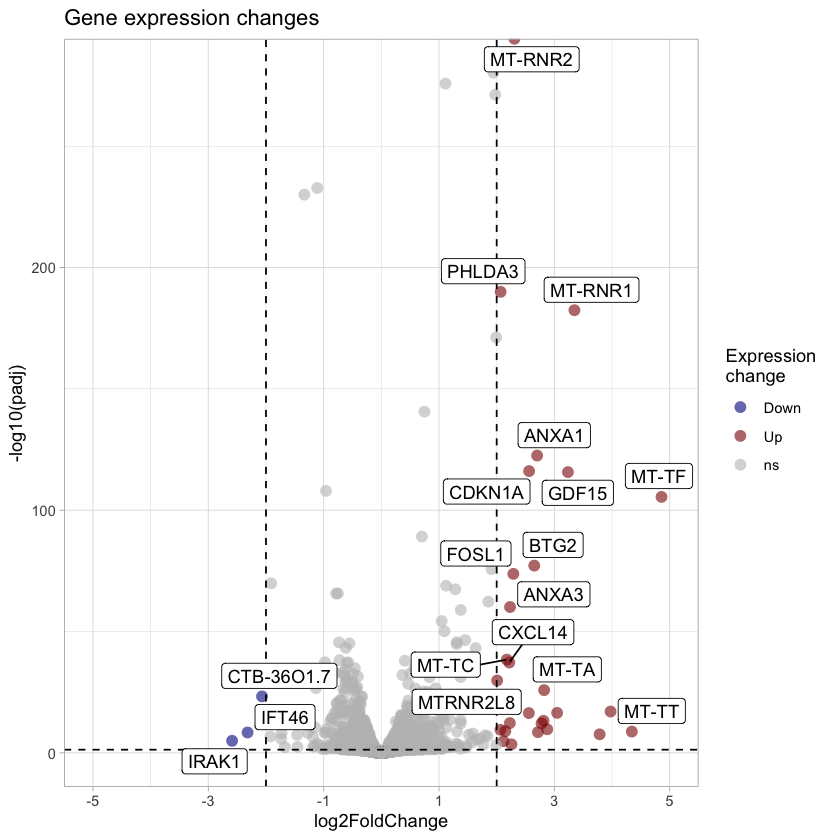

In [29]:
# Add Labels and Title
p_vol <- p_vol +
  labs(title = "Gene expression changes",
       x = "log2FoldChange",
       y = "-log10(padj)",
       colour = "Expression \nchange")

# Apply Theme
p_vol <- p_vol + theme_light()
print(p_vol)

# MA plot

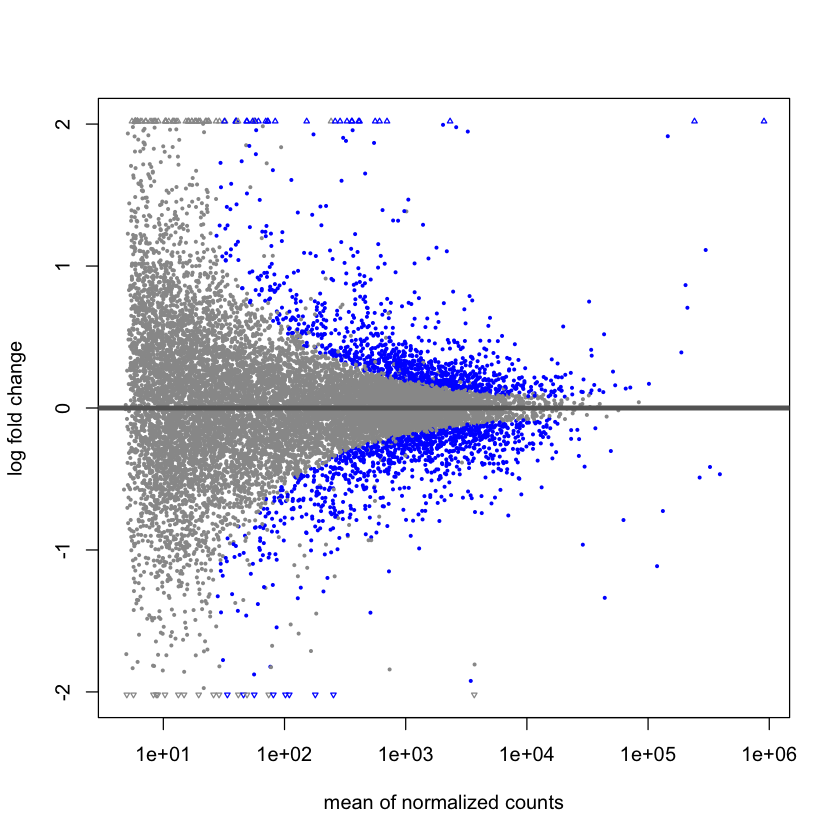

In [30]:
results <- results(dds)

# Filter significant genes
filter_cond <- results$padj < 0.05 & abs(results$log2FoldChange) > 1

# filter NA values
filter_cond <- filter_cond & !is.na(results$padj)
significant_deseq2 <- results[filter_cond, ]

# Basic visualization
plotMA(results)